In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
####### project 1 version (difference is the variance of normal distribution of coefficient, beta)
# generate simulated data 

N = 200
P = 50
sigma_ep = 0.5**2
sigma_beta = 0.5**2
piprob = 0.5

X = np.random.normal(size=(N, P))
beta = np.random.normal(0, np.sqrt(sigma_beta), size=[P,1]) * np.random.binomial(1, piprob, size=[P,1])
y = np.dot(X, beta) + np.random.normal(0, np.sqrt(sigma_ep), size=(N, 1))

0 th iteration, ELBO is -623952.6189
10 th iteration, ELBO is -1046.8313


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


20 th iteration, ELBO is -1026.7544
30 th iteration, ELBO is -1025.7366
40 th iteration, ELBO is -1025.5862
50 th iteration, ELBO is -1025.5623
60 th iteration, ELBO is -1025.5585
70 th iteration, ELBO is -1025.5579
80 th iteration, ELBO is -1025.5578
90 th iteration, ELBO is -1025.5578


Text(0, 0.5, 'ELBO')

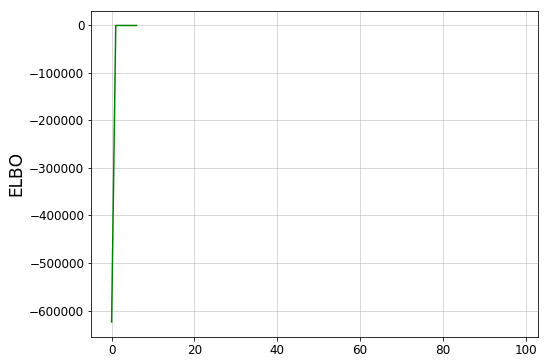

In [3]:
# initialize hyper parameters
sigma_ep = 0.2
sigma_beta = 0.2
piprob = 0.2

# initialize free parameters
mu = np.repeat(0.2, P)
svar = np.repeat(0.2, P)
alpha = np.repeat(0.2, P)

# max iteration numbers
iter_num = 100
LBseq = []
LB_old = -10000 

for k in range(iter_num):
        
    # obtain the new variational lower bound
    ELBO = - N/2*np.log(2 * np.pi * sigma_ep) - \
        np.linalg.norm(y - np.dot(X,  alpha * mu))**2 / (2 * sigma_ep) - \
        np.diag(X.T.dot(X)).dot(alpha * (svar + mu**2) - (alpha * mu)**2)/(2 * sigma_ep) - \
        np.sum(alpha * np.log(alpha/piprob)) - np.sum((1 - alpha)*np.log((1 - alpha)/(1 - piprob))) + \
        0.5*np.sum(alpha * (1 + np.log(svar / sigma_beta) - (svar + mu**2)/sigma_beta))
    
    if np.abs(ELBO - LB_old) < 1e-3:
        print("{0}th iteration stops, ELBO is {1}, posterior mean of beta is {2}, posterior variance is {3}, \
               posterior pi is {4}, sigma_ep is {5}, sigma_beta is {6}".format(k, ELBO, mu.mean(), svar.mean(), alpha.mean(), sigma_ep, sigma_beta))
        break
    else:
        # update hyper paramters
        sigma_beta = alpha.dot(svar + mu**2)/np.sum(alpha)
            
        sigma_ep = (np.linalg.norm(y - np.dot(X,  alpha * mu))**2 + np.diag(X.T.dot(X)).dot(alpha * (svar + mu**2) - (alpha * mu)**2))/N
            
        piprob = np.mean(alpha) 
        
        # update free parameters
        for j in range(P):
            mu[j] = svar[j]/(sigma_beta*sigma_ep)*(np.dot(X.T, y)[j] - ( (X.T.dot(X))[j,:]).dot(alpha*mu) + (X.T.dot(X))[j,j]*alpha[j]*mu[j])
            
            svar[j] = sigma_beta/((X.T.dot(X))[j,j]/sigma_ep + 1/sigma_beta)
            
            alpha[j] = 1/(1 + 1/(piprob/(1-piprob) * np.sqrt(svar[j]/sigma_beta) * np.exp(sigma_beta*mu[j]**2/(2*svar[j]) - sigma_beta/2 +0.5)))
                
        if k % 10 == 0:
            print("{0} th iteration, ELBO is {1}".format(k, round(ELBO, 4)))

        LB_old = ELBO
        LBseq.append(LB_old)
        
# plot setting
SMALL_SIZE = 12
MEDIUM_SIZE = 17
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

plt.figure(figsize=(8,6))
plt.grid(alpha=0.6)
plt.plot(LBseq, color="g")
plt.ylabel("ELBO")

In [20]:
### varbvs version

# generate simulated data 

# for different combinations of N (No. of samples) and P (No. of features)
N_samples = [200, 200, 500, 500, 1000, 1000]
N_features = [50, 200, 200, 500, 300, 1000]

Gen_data = []
for comb in zip(N_samples, N_features):
    N = comb[0]
    P = comb[1]
    sigma_ep = 0.5**2
    sigma_beta = 0.5**2
    piprob = 0.5

    X = np.random.normal(size=(N, P))
    beta = np.random.normal(0, np.sqrt(sigma_beta*sigma_ep), size=[P,1]) * np.random.binomial(1, piprob, size=[P,1])
    y = np.dot(X, beta) + np.random.normal(0, np.sqrt(sigma_ep), size=(N, 1))
    Gen_data.append((X,y, beta))
    
    print("No. of samples: {0}, No. of features: {1}, ratio of zero coefficients is {2}".format(N, P, (beta==0).mean()))
    

No. of samples: 200, No. of features: 50, ratio of zero coefficients is 0.44
No. of samples: 200, No. of features: 200, ratio of zero coefficients is 0.505
No. of samples: 500, No. of features: 200, ratio of zero coefficients is 0.435
No. of samples: 500, No. of features: 500, ratio of zero coefficients is 0.542
No. of samples: 1000, No. of features: 300, ratio of zero coefficients is 0.5066666666666667
No. of samples: 1000, No. of features: 1000, ratio of zero coefficients is 0.5


In [22]:
# function of mean field approximation
def mean_field_approx(data, plot_ELBO = True):
    
    X = data['X']
    y = data['y']
    
    # initialize hyper parameters
    sigma_ep = 0.2
    sigma_beta = 0.2
    piprob = 0.3

    # initialize free parameters
    N = X.shape[0]
    P = X.shape[1]
    
    mu = np.repeat(0.2, P)
    svar = np.repeat(0.2, P)
    alpha = np.repeat(0.2, P)

    # max iteration numbers
    iter_num = 500
    LBseq = []
    LB_old = -10000 

    for k in range(iter_num):

        # the variational lower bound
        ELBO = - N/2*np.log(2 * np.pi * sigma_ep) - \
            np.linalg.norm(y - np.dot(X,  alpha * mu))**2 / (2 * sigma_ep) - \
            np.diag(X.T.dot(X)).dot(alpha * (svar + mu**2) - (alpha * mu)**2)/(2 * sigma_ep) - \
            np.sum(alpha * np.log(alpha/piprob)) - np.sum((1 - alpha)*np.log((1 - alpha)/(1 - piprob))) + \
            0.5*np.sum(alpha * (1 + np.log(svar/sigma_beta/sigma_ep) - (svar + mu**2)/sigma_beta/sigma_ep))
        
        # when the difference is small enough
        if np.abs(ELBO - LB_old) < 1e-3:
            print("{0}th iteration stops, ELBO is {1}, \n\
                  posterior mean of beta is {2}, \n\
                  posterior variance is {3},\n\
                  posterior pi is {4}, \n\
                  sigma_ep is {5}, sigma_beta is {6}".format(k, round(ELBO, 5), round(mu.mean(),5), 
                   round(svar.mean(),5), round(alpha.mean(),5), round(sigma_ep,5), round(sigma_beta,5)) )
            break
        else:
            # update hyper paramters
            sigma_beta = alpha.dot(svar + mu**2)/np.sum(alpha)/sigma_ep

            sigma_ep = (np.linalg.norm(y - np.dot(X,  alpha * mu))**2 + np.diag(X.T.dot(X)).dot(alpha * (svar + mu**2) - (alpha * mu)**2) + \
                       alpha.dot(svar+mu**2)/sigma_beta)/(N + np.sum(alpha))

            piprob = np.mean(alpha) 
            #print(alpha)

            # then update free parameters
            for j in range(P):
                mu[j] = svar[j]/(sigma_ep)*(np.dot(X.T, y)[j] - ((X.T.dot(X))[j,:]).dot(alpha*mu) + (X.T.dot(X))[j,j]*alpha[j]*mu[j])

                svar[j] = sigma_ep/((X.T.dot(X))[j,j] + 1/sigma_beta)

                alpha[j] = 1/(1 + 1/(piprob/(1-piprob) * np.sqrt(svar[j]/sigma_beta/sigma_ep) * np.exp(mu[j]**2/(2*svar[j]) ) ) )


            if k % 5 == 0:
                print("{0} th iteration, ELBO is {1}".format(k, round(ELBO, 4)))

            LB_old = ELBO
            LBseq.append(LB_old)

    if plot_ELBO:
        # plot setting
        SMALL_SIZE = 12
        MEDIUM_SIZE = 17
        BIGGER_SIZE = 20

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

        plt.figure(figsize=(8,6))
        plt.grid(alpha=0.8)
        plt.plot(LBseq, color = "b")
        plt.ylabel("ELBO")
    
    # return posterior mean of beta
    return mu

(200, 50) (200, 1) (50, 1) 

0 th iteration, ELBO is -250521.2501
5 th iteration, ELBO is -901.9388
10 th iteration, ELBO is -901.9095
14th iteration stops, ELBO is -901.90389, 
                  posterior mean of beta is 0.00028, 
                  posterior variance is 0.17722,
                  posterior pi is 0.00434, 
                  sigma_ep is 483.55437, sigma_beta is 0.0004
(200, 200) (200, 1) (200, 1) 

0 th iteration, ELBO is -634666.813
5 th iteration, ELBO is -992.2738
10 th iteration, ELBO is -992.1532
15 th iteration, ELBO is -992.1264
20 th iteration, ELBO is -992.1155
24th iteration stops, ELBO is -992.11082, 
                  posterior mean of beta is 0.00092, 
                  posterior variance is 0.25125,
                  posterior pi is 0.00328, 
                  sigma_ep is 1191.81714, sigma_beta is 0.00022
(500, 200) (500, 1) (200, 1) 

0 th iteration, ELBO is -4123445.2037
5 th iteration, ELBO is -2721.5362
10 th iteration, ELBO is -2721.4611
15 th iterati

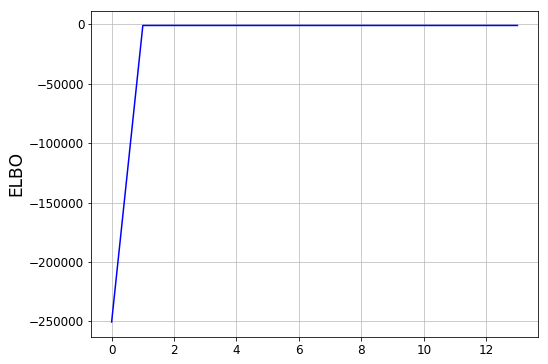

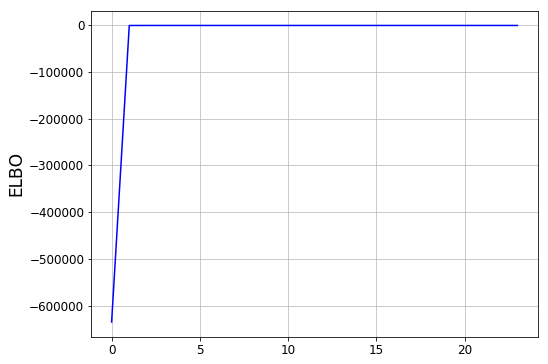

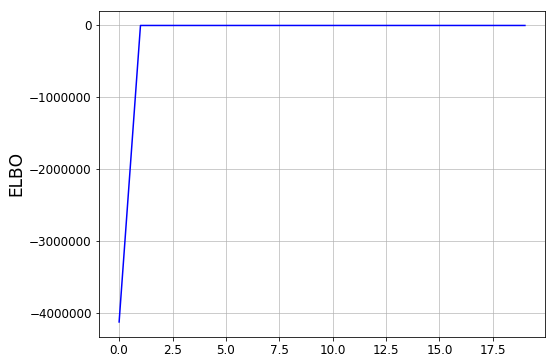

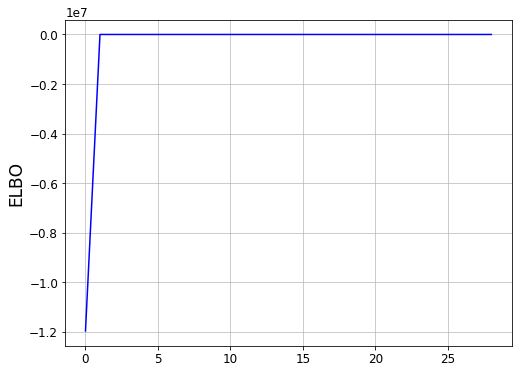

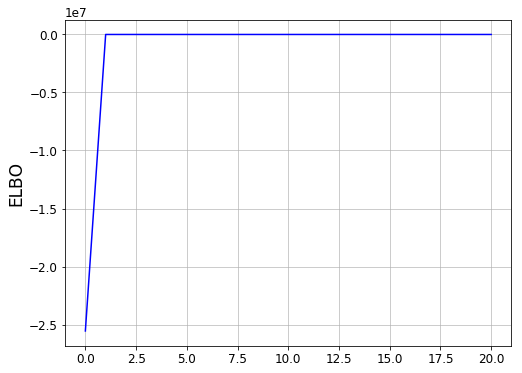

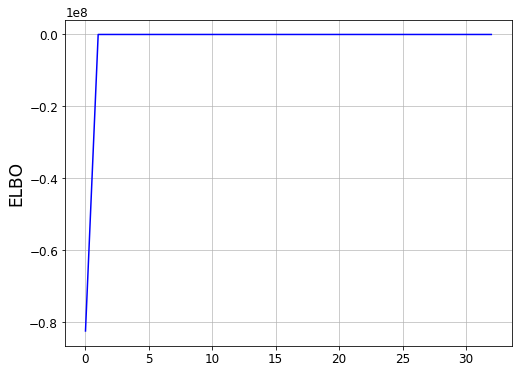

In [23]:
# save RMSE of mean field approximation on differnt simulated data
rmse_mfa = []

for gdata in Gen_data:
    data = {}
    data["X"] = gdata[0]
    data["y"] = gdata[1]
    
    print(data['X'].shape, data['y'].shape, gdata[2].shape, "\n")
    
    gmu = mean_field_approx(data)
    
    # append rmse of the posterior mean and true beta
    rmse_mfa.append(np.sqrt(((np.squeeze(gdata[2]) - gmu)**2).mean()))

In [24]:
# Compare with Lasso
from sklearn.linear_model import Lasso
import pandas as pd

def lasso_regression(data, alpha):
    # Fit
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5, fit_intercept=False)
    lassoreg.fit(data['X'],data['y'])
    
    return lassoreg.coef_

In [25]:
# Lasso with different alpha values (penalty effects)
rmse_lasso = []
for gdata in Gen_data:
    data = {}
    data["X"] = gdata[0]
    data["y"] = gdata[1]
    
    print(data['X'].shape, data['y'].shape, gdata[2].shape, "\n")

    # Test different alpha values
    alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 0.5, 1, 5, 10]

    # Use a dataframe to save estimated coefficients
    col = ['beta{0}'.format(i) for i in range(1, data['X'].shape[1]+1)]
    ind = ['alpha_{0}'.format(alpha_lasso[i]) for i in range(0,len(alpha_lasso))]
    coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

    # Iterate over different alpha values:
    for i in range(len(alpha_lasso)):
        coef_matrix_lasso.iloc[i,] = lasso_regression(data, alpha_lasso[i])

    print(coef_matrix_lasso)
    
    # append RMSE of estimated beta
    grmse = coef_matrix_lasso.apply(lambda x: np.sqrt(((x.values - gdata[2])**2).mean()), axis=1)
    rmse_lasso.append(grmse)

(200, 50) (200, 1) (50, 1) 

                   beta1      beta2      beta3      beta4        beta5  \
alpha_1e-15   0.00700273  0.0767152  0.0487707   0.171175    0.0277331   
alpha_1e-10   0.00700273  0.0767152  0.0487707   0.171175    0.0277331   
alpha_1e-08   0.00700271  0.0767151  0.0487707   0.171175     0.027733   
alpha_1e-05   0.00698401  0.0767037  0.0487411   0.171164    0.0277066   
alpha_0.0001  0.00681264  0.0766012  0.0484722    0.17106    0.0274686   
alpha_0.001   0.00505648  0.0755768  0.0457198   0.169986    0.0250535   
alpha_0.01             0   0.063657  0.0172966   0.154822  0.000215046   
alpha_0.1             -0          0         -0  0.0538277           -0   
alpha_0.5              0          0         -0          0           -0   
alpha_1                0          0         -0          0           -0   
alpha_5                0          0         -0          0           -0   
alpha_10               0          0         -0          0           -0   

        

(500, 500) (500, 1) (500, 1) 

                  beta1     beta2      beta3      beta4       beta5  \
alpha_1e-15   0.0937393  0.684217   0.163744  -0.208407  -0.0182395   
alpha_1e-10   0.0937393  0.684217   0.163744  -0.208407  -0.0182395   
alpha_1e-08   0.0937258  0.684184   0.163738  -0.208363  -0.0182465   
alpha_1e-05   0.0915659  0.674558   0.161056  -0.196795   -0.017738   
alpha_0.0001  0.0888872  0.622245   0.142394  -0.140716 -0.00425959   
alpha_0.001   0.0618741  0.509861  0.0466557 -0.0294409   0.0111346   
alpha_0.01            0   0.44594         -0          0           0   
alpha_0.1            -0  0.306136         -0         -0          -0   
alpha_0.5            -0         0         -0         -0          -0   
alpha_1              -0         0         -0          0          -0   
alpha_5              -0         0         -0          0          -0   
alpha_10             -0         0         -0          0          -0   

                   beta6       beta7      bet

In [26]:
# use a df to save rmse of mean-field-approximation and Lasso
comp_res = pd.DataFrame(rmse_lasso)
comp_res.insert(0, 'MeanFieldApprox', rmse_mfa)
comp_res.insert(0, 'P(No. of features)', N_features)
comp_res.insert(0, 'N(No. of samples)', N_samples)

comp_res

,N(No. of samples),P(No. of features),MeanFieldApprox,alpha_1e-15,alpha_1e-10,alpha_1e-08,alpha_1e-05,alpha_0.0001,alpha_0.001,alpha_0.01,alpha_0.1,alpha_0.5,alpha_1,alpha_5,alpha_10
0,200,50,0.189341,0.292274,0.292274,0.292274,0.292268,0.292211,0.291639,0.286242,0.257792,0.207161,0.205851,0.205851,0.205851
1,200,200,0.167542,0.321092,0.321091,0.321088,0.313204,0.294367,0.264296,0.237252,0.207271,0.176664,0.174361,0.174361,0.174361
2,500,200,0.171335,0.257812,0.257812,0.257812,0.257802,0.257710,0.256870,0.249877,0.212600,0.181872,0.180137,0.180137,0.180137
3,500,500,0.175718,0.291720,0.291719,0.291710,0.289246,0.278844,0.262307,0.249407,0.221243,0.187344,0.182700,0.182650,0.182650
4,1000,300,0.170906,0.255629,0.255629,0.255629,0.255623,0.255565,0.255006,0.250368,0.220253,0.181584,0.179568,0.179568,0.179568
5,1000,1000,0.164817,0.264645,0.264645,0.264634,0.260156,0.250160,0.240020,0.232412,0.205532,0.174286,0.170480,0.170444,0.170444


In [27]:
coef_matrix_lasso.apply(lambda x: sum(x==0), axis=1)

alpha_1e-15        0
alpha_1e-10        0
alpha_1e-08        0
alpha_1e-05        0
alpha_0.0001      12
alpha_0.001       94
alpha_0.01       350
alpha_0.1        660
alpha_0.5        965
alpha_1          998
alpha_5         1000
alpha_10        1000
dtype: int64

In [28]:
comp_res.to_latex()

'\\begin{tabular}{lrrrrrrrrrrrrrrr}\n\\toprule\n{} &  N(No. of samples) &  P(No. of features) &  MeanFieldApprox &  alpha\\_1e-15 &  alpha\\_1e-10 &  alpha\\_1e-08 &  alpha\\_1e-05 &  alpha\\_0.0001 &  alpha\\_0.001 &  alpha\\_0.01 &  alpha\\_0.1 &  alpha\\_0.5 &   alpha\\_1 &   alpha\\_5 &  alpha\\_10 \\\\\n\\midrule\n0 &                200 &                  50 &         0.189341 &     0.292274 &     0.292274 &     0.292274 &     0.292268 &      0.292211 &     0.291639 &    0.286242 &   0.257792 &   0.207161 &  0.205851 &  0.205851 &  0.205851 \\\\\n1 &                200 &                 200 &         0.167542 &     0.321092 &     0.321091 &     0.321088 &     0.313204 &      0.294367 &     0.264296 &    0.237252 &   0.207271 &   0.176664 &  0.174361 &  0.174361 &  0.174361 \\\\\n2 &                500 &                 200 &         0.171335 &     0.257812 &     0.257812 &     0.257812 &     0.257802 &      0.257710 &     0.256870 &    0.249877 &   0.212600 &   0.181872 &  0.18013